# Feature Visulization For MNIST 
## 1. Pre-processing and Model Construction
### (1) Load Data and Library

In [2]:
import tensorflow as tf
import numpy as np
import pickle
from tensorflow.python.platform import gfile
from random import randint
import os
import scipy.misc 
from matplotlib import pyplot as plt

/Users/gongfan/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../data/mnist', one_hot=True)

Extracting ../data/mnist/train-images-idx3-ubyte.gz
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz


### (2) Define Helper Functions

In [5]:
def weight_varible(shape):
    '''
    This function aims to create the weight variable
    '''
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    '''
    This function aims to create the bias variable
    '''
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    '''
    This function aims to construct convolution layer
    '''
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    '''
    This function aims to construct the max pooling layer
    '''
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def unpool(value, name='unpool'):
    '''
    N-dimensional version of the unpooling operation from
    https://www.robots.ox.ac.uk/~vgg/rg/papers/Dosovitskiy_Learning_to_Generate_2015_CVPR_paper.pdf
    
    parameter
    ---------
    value: A Tensor of shape [b, d0, d1, ..., dn, ch]
    
    return
    ------
    out: A Tensor of shape [b, 2*d0, 2*d1, ..., 2*dn, ch]
    '''
    with tf.name_scope(name) as scope:
        sh = value.get_shape().as_list()
        dim = len(sh[1:-1])
        out = (tf.reshape(value, [-1] + sh[-dim:]))
        for i in range(dim, 0, -1):
            out = tf.concat([out, out],i)
        out_size = [-1] + [s * 2 for s in sh[1:-1]] + [sh[-1]]
        out = tf.reshape(out, out_size, name=scope)
    return out

def plot_images(num_row, num_col, images, smooth=True):
    '''
    This function aims to make plots. 
    
    Parameter
    ---------
    num_row: The number of row of the subplots
    num_col: The number of column of the subplots
    images: A numpy array has the shape [i, :, :]. i is the number of picture we have.
    '''
    
    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    # Create figure with sub-plots.
    fig, axes = plt.subplots(num_row, num_col)

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # For each entry in the grid.
    for i, ax in enumerate(axes.flat):
        # Get the i'th image and only use the desired pixels.
        img = images[i, :, :]
        
        # Plot the image.
        ax.imshow(img, interpolation=interpolation, cmap='binary')

        # Remove ticks.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### (3) CNN Model Construction

In [6]:
batchsize = 50
imagesize = 28

sess = tf.InteractiveSession()
# paras
W_conv1 = weight_varible([5, 5, 1, 32])
b_conv1 = bias_variable([32])

# conv layer-1
x = tf.placeholder(tf.float32, [None, 784])
x_image = tf.reshape(x, [-1, 28, 28, 1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# conv layer-2
W_conv2 = weight_varible([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# full connection
W_fc1 = weight_varible([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# output layer: softmax
W_fc2 = weight_varible([1024, 10])
b_fc2 = bias_variable([10])

logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

y_conv = tf.nn.softmax(logits)
y_ = tf.placeholder(tf.float32, [None, 10])

# model training
cross_entropy = -tf.reduce_sum(y_ * tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess.run(tf.global_variables_initializer())


for i in range(1000):
    batch = mnist.train.next_batch(50)

    if i % 100 == 0:
        train_accuacy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
        ##t.eval() is a shortcut for calling tf.get_default_session().run(t)
        print("step %d, training accuracy %g"%(i, train_accuacy))
    train_step.run(feed_dict = {x: batch[0], y_: batch[1], keep_prob: 0.5})

# accuacy on test
print("test accuracy %g"%(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})))

step 0, training accuracy 0.08
step 100, training accuracy 0.84
step 200, training accuracy 0.88
step 300, training accuracy 0.88
step 400, training accuracy 0.94
step 500, training accuracy 0.94
step 600, training accuracy 0.98
step 700, training accuracy 0.98
step 800, training accuracy 0.98
step 900, training accuracy 1
test accuracy 0.9662


## 2. Deconvolution Feature Visualization
### (1) Reconstruction From The Layer CNV-1

In [7]:
featuresReLu_1 = tf.placeholder(tf.float32,[None,14,14,32])
unPool_1 = unpool(featuresReLu_1)
unReLu_1 = tf.nn.relu(unPool_1)
unBias_1 = unReLu_1
unBias_1
#unConv = tf.nn.conv2d_transpose(unBias, W_conv1, output_shape=[1,28,28,1] , strides=[1,1,1,1], padding="SAME")
unConv_1 = tf.nn.conv2d_transpose(unBias_1, W_conv1, output_shape=[batchsize,28,28,1] , strides=[1,1,1,1], padding="SAME")

In [8]:
#Get the features from the layer CNV-1
activations1 = h_pool1.eval(feed_dict={x: mnist.train.next_batch(50)[0], y_: mnist.train.next_batch(50)[1]})
print (activations1.shape)

(50, 14, 14, 32)


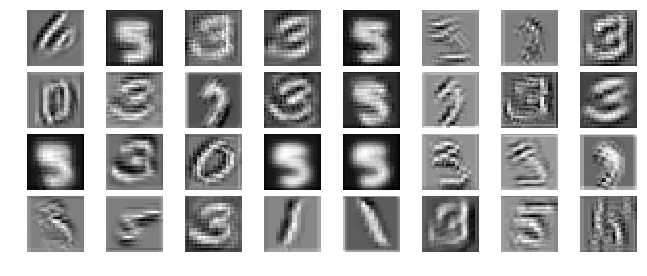

In [9]:
#get every feature (1, 14, 14, 1) from activations1 than reconstruct from 
plt.figure(num='CNV1',figsize=(10,8))
for i in range(32):
    isolated = activations1.copy()
    isolated[:,:,:,:i] = 0
    isolated[:,:,:,i+1:] = 0#These two lines set all other features other than feature i to 0
    #print (isolated.shape)
    totals = np.sum(isolated,axis=(1,2,3))
    best = np.argmax(totals,axis=0)
    #These two lines are particular for batch of images.
    #That means choose one image from this batch of images which feacture i can judge best.
    #print (totals)
    pixelactive = unConv_1.eval(feed_dict={featuresReLu_1: isolated})
    #print(pixelactive.shape) 
    #shape of every pixelactive is (50, 28, 28, 1) batchsize=50 picsize=28*28 colors=1
    plt.subplot(4,8,i+1)    
    plt.imshow(pixelactive[best,:,:,0],cmap="gray")
    plt.axis('off') 
plt.subplots_adjust(top=0.5, bottom=0.08, left=0.10, right=0.95, hspace=0.1,
                    wspace=0.35)
plt.show()

### (2) Reconstruction From The Layer CNV-2

In [10]:
#Get the features from the layer CNV-2
activations2 = h_pool2.eval(feed_dict={x: mnist.train.next_batch(50)[0], y_: mnist.train.next_batch(50)[1]})
print (activations2.shape)

(50, 7, 7, 64)


In [11]:
#Reconstruction from the layer CNV-2
featuresReLu_2 = tf.placeholder(tf.float32,[None,7,7,64])
unPool_2 = unpool(featuresReLu_2)
unReLu_2 = tf.nn.relu(unPool_2)
unBias_2 = unReLu_2
unBias_2
#unConv = tf.nn.conv2d_transpose(unBias, W_conv1, output_shape=[1,28,28,1] , strides=[1,1,1,1], padding="SAME")
unConv_2 = tf.nn.conv2d_transpose(unBias_2, W_conv2, output_shape=[batchsize,14,14,32] , strides=[1,1,1,1], padding="SAME")
unPool_1 = unpool(unConv_2)
unReLu_1 = tf.nn.relu(unPool_1)
unBias_1 = unReLu_1
unBias_1
#unConv = tf.nn.conv2d_transpose(unBias, W_conv1, output_shape=[1,28,28,1] , strides=[1,1,1,1], padding="SAME")
unConv_1 = tf.nn.conv2d_transpose(unBias_1, W_conv1, output_shape=[batchsize,28,28,1] , strides=[1,1,1,1], padding="SAME")

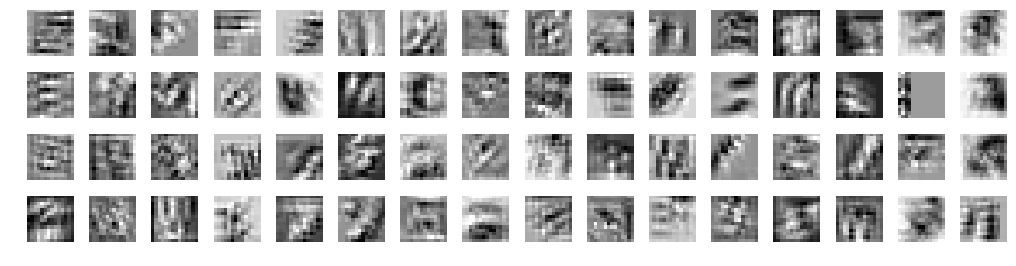

In [12]:
#get every feature (1, 14, 14, 1) from activations1 than reconstruct from 
plt.figure(num='CNV2',figsize=(16,8))
for i in range(64):
    isolated = activations2.copy()
    isolated[:,:,:,:i] = 0
    isolated[:,:,:,i+1:] = 0#These two lines set all other features other than feature i to 0
    #print (isolated.shape)
    totals = np.sum(isolated,axis=(1,2,3))
    best = np.argmax(totals,axis=0)
    #These two lines are particular for batch of images.
    #That means choose one image from this batch of images which feacture i can judge best.
    #print (totals)
    pixelactive = unConv_2.eval(feed_dict={featuresReLu_2: isolated})
    #print(pixelactive.shape) 
    #shape of every pixelactive is (50, 28, 28, 1) batchsize=50 picsize=28*28 colors=1
    plt.subplot(4,16,i+1)    
    plt.imshow(pixelactive[best,:,:,0],cmap="gray")
    plt.axis('off') 
plt.subplots_adjust(top=0.5, bottom=0.08, left=0.10, right=0.95, hspace=0.1,
                    wspace=0.35)
plt.show()

### (3) Reconstruction From the Fully-Connected Layer

In [13]:
activations3 = h_fc1.eval(feed_dict={x: mnist.train.next_batch(50)[0], y_: mnist.train.next_batch(50)[1]})
activations3.shape

(50, 1024)

## 3. Feature Maximization Visualization 
### (1) Define Helper Function 

In [14]:
def optimize_image(conv_layer, feature=0,
                   num_iterations=30, show_progress=True):
    """
    This function aims to find an image that maximizes the feature given by the 
    convlution layer and feature number

    Parameter
    ---------
    conv_layer: Tensor that identifying the convolutional layer to
             maximize. If None then use the last fully-connected layer before the softmax output.
    feature: Index into the layer for the feature to maximize.
    
    num_iteration: Number of optimization iterations to perform.
    
    show_progress: Boolean whether to show the progress.
    
    Return
    ------
    image.squeeze(): A numpy array contains the output information 
    
    """

    # Create the loss-function that must be maximized.
    if conv_layer is None:
        
        # The loss-function is just the value of that feature.
        loss = tf.reduce_mean(logits[:, feature])
    else:

        # The loss-function is the average of all the tensor-values for the given feature. 
        loss = tf.reduce_mean(conv_layer[:, :, :, feature])
        
    # Get the gradient for the loss-function with regard to the input image. 
    gradient = tf.gradients(loss, x_image)

    # Use one of the training image as the test image
    image = mnist.train.next_batch(1)[0]
    image = image.reshape((28,28))

    # Perform a number of optimization iterations to find the image that maximizes the loss-function.
    for i in range(num_iterations):
        # Reshape the array so it is a 4-rank tensor.
        img_reshaped = image[np.newaxis,:,:,np.newaxis]
        img_ori = img_reshaped.reshape((-1,784))

        # Create a feed-dict for inputting the image to the graph.
        feed_dict = {keep_prob: 1.0, x: img_ori, x_image: img_reshaped}
       

        # Calculate the predicted class-scores as well as the gradient and the loss-value.
        pred, grad, loss_value = sess.run([y_conv, gradient, loss],
                                             feed_dict=feed_dict)
        
        # Squeeze the dimensionality for the gradient-array. (Back to 28 * 28)
        grad = np.array(grad).squeeze()

        # The gradient now tells us how much we need to change the input image in order to maximize the given feature.

        # Calculate the step-size for updating the image. This step-size was found to give fast convergence.
        step_size = 1.0 / (grad.std() + 1e-8)
        
        # Gradient ascent.
        image += step_size * grad

        # Ensure all pixel-values in the image are between 0 and 1.
        image = np.clip(image, 0.0, 1.0)

        if show_progress:
            
            if i % 30 == 0:
                
                print("Iteration:", i)
    
                # Convert the predicted class-scores to a one-dim array.
                pred = np.squeeze(pred)
    
                # The predicted class for the Inception model.
                pred_cls = np.argmax(pred)
    
                # The score (probability) for the predicted class.
                cls_score = pred[pred_cls]
    
                # Print the predicted score etc.
                msg = "Predicted class: {0}, score: {1:>7.2%}"
                print(msg.format(pred_cls, cls_score))
    
                # Print statistics for the gradient.
                msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
                print(msg.format(grad.min(), grad.max(), step_size))
    
                # Print the loss-value.
                print("Loss:", loss_value)
    
                # Newline.
                print()

    return image.squeeze()

# finds the images that maximize all the features of a layer
def optimize_images(conv_layer=None, num_iterations=30, show_progress = True):
    """
    This functions aims to find 10 images that maximizes the 10 first features in the layer
    given by the convolution layer.
    
    Parameter
    ---------
    conv_layer : Tensor identifying the convolutional layer to maximize. 
    If None then use the last layer before the softmax output.
    
    num_iterations: Number of optimization iterations to perform.
    
    show_progress: whether or not to show the progress
    """

    # Which layer are we using?
    if conv_layer is None:
        print("Final fully-connected layer before softmax.")
    else:
        print("Layer:", conv_layer.name)

    # Initialize the array of images.
    images = []

    # For each feature do the following.
    for feature in range(int(conv_layer.shape[-1])):
        #print("Optimizing image for feature no.", feature)
        
        # Find the image that maximizes the given feature
        image = optimize_image(conv_layer=conv_layer, feature=feature,
                               show_progress= show_progress,
                               num_iterations=num_iterations)

        # Squeeze the dim of the array.
        image = image.squeeze()

        # Append to the list of images.
        images.append(image)

    # Convert to numpy-array so we can index all dimensions easily.
    images = np.array(images)

    # Plot the images.
    plot_images(num_row = int(int(conv_layer.shape[-1])/8), num_col = 8 ,images=images)

### (2) Maximize The Features In Layer CNV-1

Layer: Relu:0


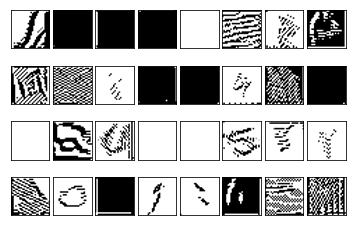

In [16]:
optimize_images(h_conv1, show_progress = False)

### (3) Maximize The Features In Layer CNV-2

Layer: Relu_1:0


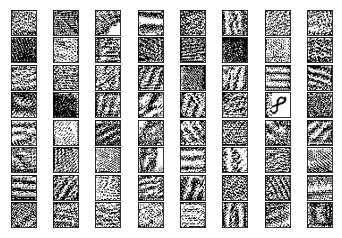

In [17]:
optimize_images(h_conv2, show_progress = False)